(60, 160, 3)


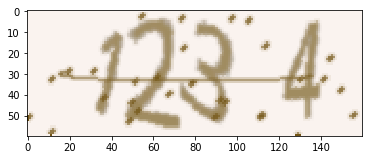

In [1]:
#############   generate data   ################
from captcha.image import ImageCaptcha
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

text = '1234'
image = ImageCaptcha()
captcha = image.generate(text)
captcha_image = Image.open(captcha)
#captcha_image.show()
plt.imshow(captcha_image)
print(np.array(captcha_image).shape)

We can find the picture generated by ImageCaptcha the GBR scale lies in the last demention, but the pytoch need it in the fist. As a result, the picture must be translated in dementions.

In [2]:
VOCAB = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
CAPTCHA_LENGTH = 4
VOCAB_LENGTH = len(VOCAB)

In [3]:
from captcha.image import ImageCaptcha
import numpy as np

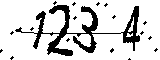

In [4]:
def image_deal(image):
##########   图片转灰度处理   ############
    image = image.convert('L')
#     image = image.resize((28, 28)) # 缩放
    
##########   图片二值化处理   ############
    # 阈值
    threshold = 180
    table = []
    for i in range(256):
        if i < threshold:
            table.append(0)
        else:
            table.append(1)
    # 图片二值化，此处第二个参数为数字一
    image = image.point(table, '1') #table 中含有256个值，分别对应256个像素点的映射值, 0是最黑的， 1是最白的
    
    return image

image_deal(captcha_image)

In [30]:
# def generate_captcha(captcha_text):
#     '''
#     get captcha text
#     return np array of captcha image
#     '''
#     image = ImageCaptcha()
#     captcha = image.generate(captcha_text)
#     captcha_image = Image.open(captcha)
#     captcha_image = image_deal(captcha_image)
#     captcha_array = np.array(captcha_image)
#     captcha_array = captcha_array[np.newaxis,:,:]
    
#     return captcha_array

def generate_captcha(captcha_text):
    '''
    get captcha text
    return np array of captcha image
    '''
    image = ImageCaptcha()
    captcha = image.generate(captcha_text)
    captcha_image = Image.open(captcha)
#     captcha_image = image_deal(captcha_image)
    a = np.array(captcha_image)
    
    a_0 = list(a[:,:,0])
    a_1 = list(a[:,:,1])
    a_2 = list(a[:,:,2])
    a_ = []
    a_.append(a_0)
    a_.append(a_1)
    a_.append(a_2)
    a_ = np.array(a_)
    return a_

In [28]:
def text2vec(text):
    '''
    text to vector
    :param text: source text
    :return: np array
    '''
    if len(text) > CAPTCHA_LENGTH:
        return False
    
    vector = np.zeros(CAPTCHA_LENGTH * VOCAB_LENGTH)
    
    for i, c in enumerate(text):
        index = i * VOCAB_LENGTH + VOCAB.index(c)
        vector[index] = 1
    return vector

def vec2text(vector):
    '''
    vector to text
    :param text: source vector
    :return: text'''
    if len(vector) != 40:
        return False
    
    if not isinstance(vector, np.ndarray):
        vector = np.asarray(vector)
    
    text = ''
    
    for i in range(0,4):
        text += VOCAB[np.argmax(vector[i*10:(i+1)*10])]
    
    return text

t = '0234'
print(vec2text(text2vec(t)))

0234


In [7]:
import random
from os.path import join, exists
import pickle
import numpy as np
from os import makedirs

DATA_LENGTH = 1000
DATA_PATH = 'data'

def get_random_text():
    text = ''
    for i in range(CAPTCHA_LENGTH):
        text += random.choice(VOCAB)
    return text

In [8]:
def generate_data():
    print('Generating Data...')
    data_x, data_y = [], []

    # generate data x and y
    for i in range(DATA_LENGTH):
        text = get_random_text()
        # get captcha array
        captcha_array = generate_captcha(text)
        # get vector
        vector = text2vec(text)
        data_x.append(captcha_array)
        data_y.append(vector)

    # write data to pickle
    if not exists(DATA_PATH):
        makedirs(DATA_PATH)

    x = np.asarray(data_x, np.float32)
    y = np.asarray(data_y, np.float32)
    with open(join(DATA_PATH, 'data.pkl'), 'wb') as f:
        pickle.dump(x, f)
        pickle.dump(y, f)
        

In [9]:
generate_data()
with open(join(DATA_PATH,'data.pkl'), 'rb') as f:
    data_x = pickle.load(f)
    data_y = pickle.load(f)

Generating Data...


In [10]:
from sklearn.cross_validation import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.4, random_state=40)
print(train_x.shape)

(600, 3, 60, 160)


/home/lsc/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch

class CaptchaDataset(Dataset):
    def __init__(self, x, y, transform=None):
        super(Dataset, self).__init__()
        self.x = x
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, n):
#         self.x[n] = image_deal(self.x[n])
#         self.y[n] = image_deal(self.y[n])
#         self.x[n] = self.x[n][np.newaxis,:,:]
        return self.x[n], self.y[n]

In [13]:
from torchvision import transforms

captcha_train_dataset = CaptchaDataset(train_x, train_y, transform=transforms.ToTensor())
captcha_test_dataset = CaptchaDataset(test_x, test_y, transform=transforms.ToTensor())
train_data = DataLoader(captcha_train_dataset, batch_size=100, shuffle=True)
test_data = DataLoader(captcha_test_dataset, batch_size=100, shuffle=False)
for i, j in train_data:
	break

print(i.shape, i[1], j.shape, j.long())

torch.Size([100, 3, 60, 160]) tensor([[[255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         ...,
         [255., 248., 248.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.]],

        [[238., 238., 238.,  ..., 238., 238., 238.],
         [238., 238., 238.,  ..., 238., 238., 238.],
         [238., 238., 238.,  ..., 238., 238., 238.],
         ...,
         [238., 228., 228.,  ..., 238., 238., 238.],
         [238., 238., 238.,  ..., 238., 238., 238.],
         [238., 238., 238.,  ..., 238., 238., 238.]],

        [[250., 250., 250.,  ..., 250., 250., 250.],
         [250., 250., 250.,  ..., 250., 250., 250.],
         [250., 250., 250.,  ..., 250., 250., 250.],
         ...,
         [250., 236., 236.,  ..., 250., 250., 250.],
         [250., 250., 250.,  ..., 250., 250., 250.],
         [250., 250., 2

In [31]:
###################   leNet   ################
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable

class LeNet(nn.Module):
    def __init__(self):
        # nn.Module的子类函数必须在构造函数中执行父类的构造函数
        super(LeNet, self).__init__()   # 等价与nn.Module.__init__()

        # nn.Conv2d返回的是一个Conv2d class的一个对象，该类中包含forward函数的实现
        # 当调用self.conv1(input)的时候，就会调用该类的forward函数
        self.conv1 = nn.Conv2d(3, 32, (5, 5))   # output (N, C_{out}, H_{out}, W_{out})`, 图片的维度减少4*4
        self.conv2 = nn.Conv2d(32, 16, (5, 5))
        # self.conv3 = nn.Conv2d(16, 16, (5, 5))
        self.fc1 = nn.Linear(7104, 2000)
        self.fc2 = nn.Linear(2000, 840)
        self.fc3 = nn.Linear(840, 40)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # 
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2)) # 
        x = x.view(x.size()[0], -1) #16*56*156=139776
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return x



net = LeNet()
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

for e in range(25):
	for data, label in train_data:
		data = Variable(data)
		label = Variable(label)
		#frontward
		out = net(data)
		loss = criterion(out, label)
		#backward
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()


	########eval#########
	num_correct = 0
	for data, label in test_data:
		data = Variable(data)
		label = Variable(label)
		#frontward
		out = net(data)
		loss = criterion(out, label)

		_, pred = out.max(1)
# 		num_correct += float((pred == label).sum().data)
		
# 	if e % 5 == 0:
	print("Epoch:", '%04d' % (e+1), "loss=", "%04f" % loss)

Epoch: 0001 loss= 0.693145
Epoch: 0002 loss= 0.693136
Epoch: 0003 loss= 0.693136
Epoch: 0004 loss= 0.693136
Epoch: 0005 loss= 0.693136
Epoch: 0006 loss= 0.693136
Epoch: 0007 loss= 0.693136
Epoch: 0008 loss= 0.693136
Epoch: 0009 loss= 0.693136
Epoch: 0010 loss= 0.693136
Epoch: 0011 loss= 0.693136
Epoch: 0012 loss= 0.693136
Epoch: 0013 loss= 0.693136
Epoch: 0014 loss= 0.693136
Epoch: 0015 loss= 0.693136
Epoch: 0016 loss= 0.693136
Epoch: 0017 loss= 0.693136
Epoch: 0018 loss= 0.693136
Epoch: 0019 loss= 0.693136
Epoch: 0020 loss= 0.693136
Epoch: 0021 loss= 0.693136
Epoch: 0022 loss= 0.693136
Epoch: 0023 loss= 0.693136
Epoch: 0024 loss= 0.693136
Epoch: 0025 loss= 0.693136


(60, 160, 3)


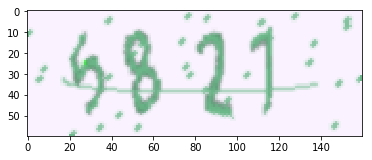

In [15]:
text = '5827'
image = ImageCaptcha()
captcha = image.generate(text)
captcha_image = Image.open(captcha)
#captcha_image.show()
plt.imshow(captcha_image)
print(np.array(captcha_image).shape)

In [35]:
def generate_test_captcha(captcha_text):
    '''
    get captcha text
    return np array of captcha image
    '''
    image = ImageCaptcha()
    captcha = image.generate(captcha_text)
    captcha_image = Image.open(captcha)
#     captcha_image = image_deal(captcha_image)
    a = np.array(captcha_image)
    
    a_0 = list(a[:,:,0])
    a_1 = list(a[:,:,1])
    a_2 = list(a[:,:,2])
    a_ = []
    a_.append(a_0)
    a_.append(a_1)
    a_.append(a_2)
    a_ = np.array(a_)
    return captcha_image, a_

def text2vec(text):
    '''
    text to vector
    :param text: source text
    :return: np array
    '''
    if len(text) > CAPTCHA_LENGTH:
        return False
    
    vector = np.zeros(CAPTCHA_LENGTH * VOCAB_LENGTH)
    
    for i, c in enumerate(text):
        index = i * VOCAB_LENGTH + VOCAB.index(c)
        vector[index] = 1
    return vector

def vec2text(vector):
    '''
    vector to text
    :param text: source vector
    :return: text'''
    if len(vector) != 40:
        return False
    
    if not isinstance(vector, np.ndarray):
        vector = np.asarray(vector)
    
    text = ''
    
    for i in range(0,4):
        text += VOCAB[np.argmax(vector[i*10:(i+1)*10])]
    
    return text

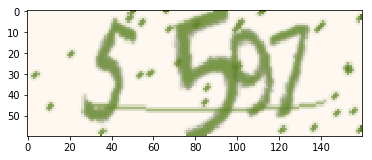

In [36]:
test_text = get_random_text()
test_image, test_array = generate_test_captcha(test_text)
plt.figure()
plt.imshow(test_image)

In [37]:
test_array = test_array.astype(float)
test_variable = Variable(torch.Tensor(test_array))
test_variable.unsqueeze_(0)
out = net(test_variable)
print(type(out), type(out.data.numpy()))
out = out.squeeze_(0).data.cpu().numpy()  
test_net = vec2text(out)
out, test_net

<class 'torch.Tensor'> <class 'numpy.ndarray'>


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], dtype=float32), '0000')